# Changelog:
- v3.0: loss menggunakan binary_crossentropy
- v3.1: print confusion matrix using sklearn
- v4.0: pake augmentation + base_model dari keras
- v4.1: benerin dense akhir ke sigmoid
- v5.0: ganti metode load data + base model tetep di MobileNetV2

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load Images

In [5]:
labels = ['neutral', 'porn']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
train = get_data('dataset_80-20/train')
val = get_data('dataset_80-20/test')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (4480, 2) + inhomogeneous part.

In [3]:
# Check for image labels
class_labels = list(train_data.class_indices.keys())
print("Class labels:", class_labels)

Class labels: ['neutral', 'porn']


Check for images preview. **NSFW WARNING!!**

In [4]:
# images, labels = next(val_data)

# plt.figure(figsize=(10, 10))
# for i in range(12):
#     ax = plt.subplot(3, 4, i + 1)
#     plt.imshow(images[i])
#     label_index = np.argmax(labels[i])
#     plt.title(class_labels[label_index])
#     plt.axis("off")
# plt.show()

# Define Model

In [5]:
IMG_SHAPE = (img_height, img_width)+(3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2448\2931805324.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


In [6]:
base_model.trainable = False

In [17]:
# Add new classification layers on top
inputs = tf.keras.Input(shape=(255, 255, 3))

x = base_model(x)

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_data.num_classes, activation='softmax')
])

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

# Compile and Train

In [9]:
base_learning_rate = 0.0001 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [10]:
initial_epochs = 10
history = model.fit(train_data,
                    epochs=initial_epochs-7,
                    validation_data=val_data)

Epoch 1/3


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.7876 - loss: 0.4334 - val_accuracy: 0.9445 - val_loss: 0.1639
Epoch 2/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9410 - loss: 0.1640 - val_accuracy: 0.9484 - val_loss: 0.1434
Epoch 3/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9492 - loss: 0.1356 - val_accuracy: 0.9512 - val_loss: 0.1356


In [11]:
loss, accuracy = model.evaluate(test_data)
print('Test accuracy :', accuracy)

40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9372 - loss: 0.1844
Test accuracy : 0.9375


In [12]:
# model.save('model_v5.0.keras')

# Model Evaluation

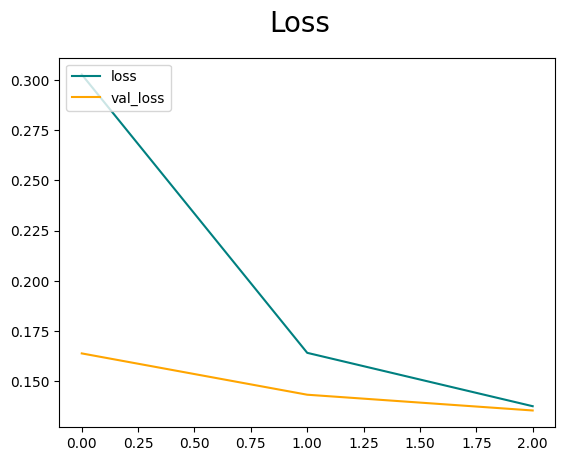

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 3
epochs_range = range(epochs)

fig = plt.figure()
plt.plot(epochs_range, loss, color='teal', label='loss')
plt.plot(epochs_range, val_loss, color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

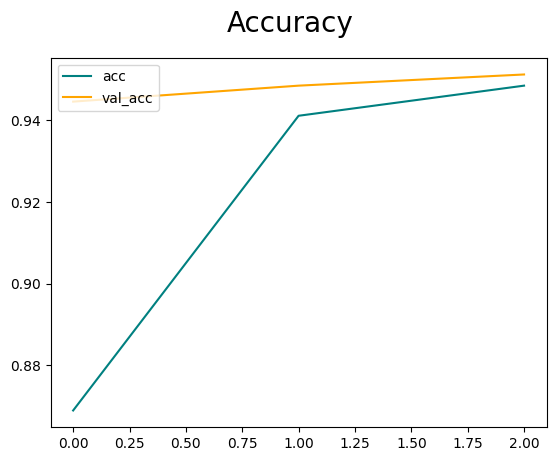

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

fig = plt.figure()
plt.plot(epochs_range, acc, color='teal', label='acc')
plt.plot(epochs_range, val_acc, color='orange', label='val_acc')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 778ms/step
[[640   0]
 [640   0]]


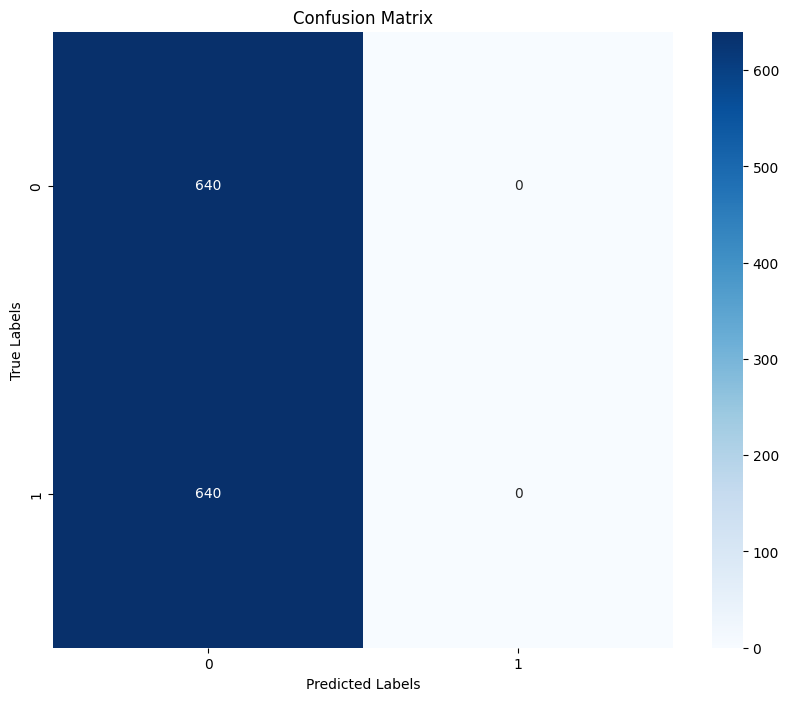

              precision    recall  f1-score   support

     neutral       0.50      1.00      0.67       640
        porn       0.00      0.00      0.00       640

    accuracy                           0.50      1280
   macro avg       0.25      0.50      0.33      1280
weighted avg       0.25      0.50      0.33      1280



c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [15]:
test_data.reset()  # Resetting the generator as a precaution
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels
true_classes = test_data.classes

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Optionally, you can also print a classification report
class_labels = list(test_data.class_indices.keys())
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [16]:
asdds

NameError: name 'asdds' is not defined

# Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Unfreeze the remaining layers
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
# model.save('model_v4.1.keras')

In [ ]:
fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 3/12


KeyboardInterrupt: 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

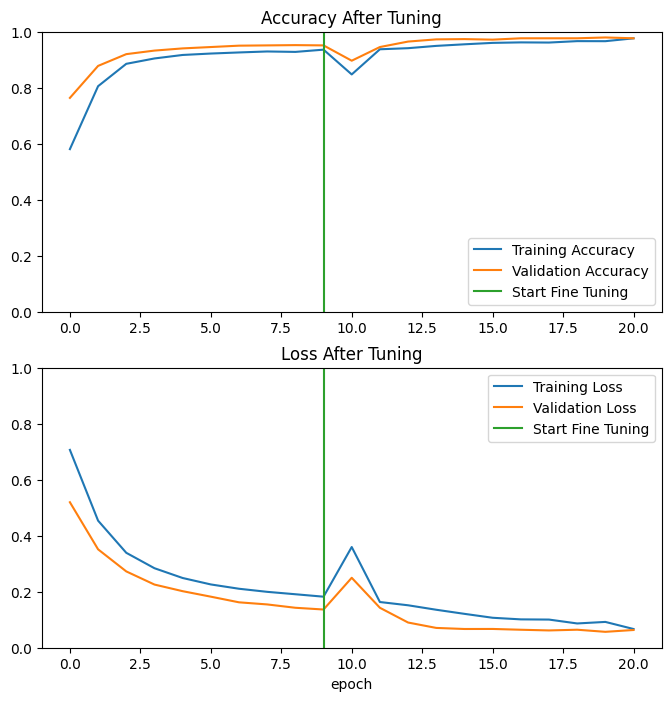

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Accuracy After Tuning')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Loss After Tuning')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 806ms/step - accuracy: 0.9948 - loss: 0.0246
Test accuracy : 0.98828125


In [ ]:
y_prob= model.predict(test_ds)
y_pred = y_prob.argmax(axis=1)
y_pred = list(map(lambda x: class_names[x],y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 812ms/step


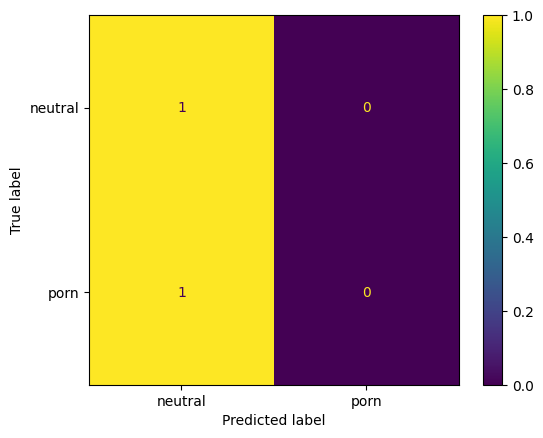

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred, normalize = 'true')

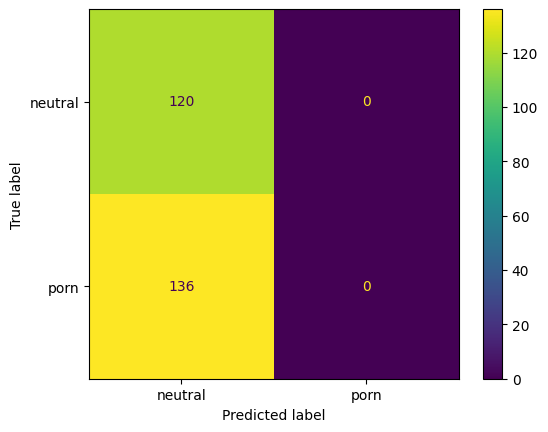

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [ ]:
model.save('model_v4.1.keras')

TypeError: BinaryCrossentropy.get_config() missing 1 required positional argument: 'self'